# Rashmi Kiran FDS Assignment

First 5 rows of X:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  

First 5 values of y:
0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

Info about X:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  flo

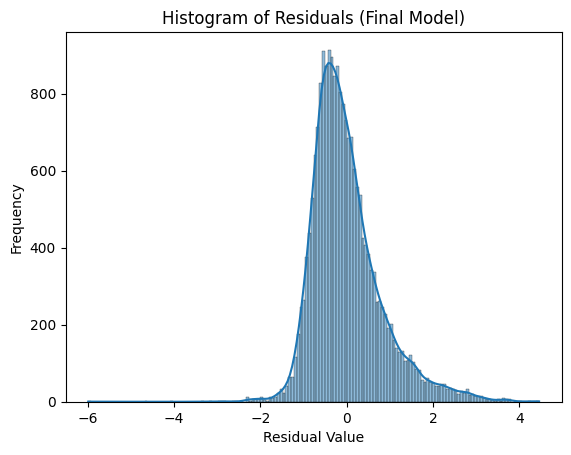


Shapiro-Wilk Test Statistic: 0.927, p-value: 0.000
Residuals do not appear to be normally distributed (reject H0)

Breusch-Pagan Test Results:
LM Statistic: 462.9465
LM Test p-value: 0.0000
F-Statistic: 78.9013
F-Test p-value: 0.0000

MAPE (Test Set, final model): 37.72%


c:\Users\Rashmi\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20640.
  res = hypotest_fun_out(*samples, **kwds)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.api import het_breuschpagan
from scipy.stats import shapiro

# ==========================
# 1. Load Dataset
# ==========================
california_housing = fetch_california_housing()
X_full = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = pd.Series(california_housing.target, name="MedHouseVal")

print("First 5 rows of X:")
print(X_full.head())
print("\nFirst 5 values of y:")
print(y.head())
print("\nInfo about X:")
print(X_full.info())
print("X shape:", X_full.shape)
print("y shape:", y.shape)

# ==========================
# 2. VIF Calculation (Iterative)
#    Remove variables with high VIF one by one
#    NOTE: VIF is computed with a constant in the design matrix
# ==========================

def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate VIF for each feature in df, using a design matrix that
    includes a constant (intercept). The returned VIF values correspond
    only to the original features (constant is excluded).
    """
    # Add constant
    X_with_const = sm.add_constant(df)
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns  # only the actual features, not the constant
    
    # variance_inflation_factor expects the full matrix (with constant),
    # but we skip index 0 (the constant) and compute for each feature.
    vif_data["VIF"] = [
        variance_inflation_factor(X_with_const.values, i + 1)  # +1 to skip const at index 0
        for i in range(df.shape[1])
    ]
    return vif_data

# You can choose your own threshold; 5 or 10 are common.
# If you want to be extremely strict, you can set this to 1.5 like before.
VIF_THRESHOLD = 5.0

X_vif = X_full.copy()

while True:
    vif_table = calculate_vif(X_vif)
    print("\nCurrent VIFs:")
    print(vif_table)

    max_vif = vif_table["VIF"].max()
    if max_vif <= VIF_THRESHOLD:
        print(f"\nAll VIF values are now <= {VIF_THRESHOLD}. Stopping elimination.")
        break

    # Feature with highest VIF
    feature_to_drop = vif_table.sort_values("VIF", ascending=False)["feature"].iloc[0]
    print(f"\nDropping feature '{feature_to_drop}' with VIF = {max_vif:.3f}")
    X_vif = X_vif.drop(columns=[feature_to_drop])

print("\nFinal set of features after VIF-based elimination:")
print(X_vif.columns.tolist())

# This is the final X to be used for modeling
X = X_vif

# ==========================
# 3. Train-Test Split with Reduced Features
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# ==========================
# 4. Train Linear Regression (sklearn)
# ==========================
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

# ==========================
# 5. OLS Regression (statsmodels) on full data with reduced X
# ==========================
X_with_constant = sm.add_constant(X)
ols_model = sm.OLS(y, X_with_constant).fit()

print("\nOLS Regression Summary (after VIF-based feature selection):")
print(ols_model.summary())

# ==========================
# 6. Durbin-Watson Test
# ==========================
residuals = ols_model.resid
dw_statistic = durbin_watson(residuals)
print(f"\nDurbin-Watson statistic: {dw_statistic:.4f}")

# ==========================
# 7. Residual Histogram
# ==========================
plt.figure()
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals (Final Model)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

# ==========================
# 8. Shapiro-Wilk Test (Normality of residuals)
# ==========================
stat, p = shapiro(residuals)
print(f"\nShapiro-Wilk Test Statistic: {stat:.3f}, p-value: {p:.3f}")
if p > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H0)")
else:
    print("Residuals do not appear to be normally distributed (reject H0)")

# ==========================
# 9. Breusch-Pagan Test (Heteroskedasticity)
# ==========================
bp_lm_stat, bp_lm_p_value, bp_f_stat, bp_f_p_value = het_breuschpagan(
    residuals, X_with_constant
)

print("\nBreusch-Pagan Test Results:")
print(f"LM Statistic: {bp_lm_stat:.4f}")
print(f"LM Test p-value: {bp_lm_p_value:.4f}")
print(f"F-Statistic: {bp_f_stat:.4f}")
print(f"F-Test p-value: {bp_f_p_value:.4f}")

# ==========================
# 10. MAPE on Test Set (using reduced-feature sklearn model)
# ==========================
mape_result = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"\nMAPE (Test Set, final model): {mape_result:.2f}%")


In [2]:
print("\nCurrent VIFs:")
print(vif_table)



Current VIFs:
      feature       VIF
0      MedInc  1.022435
1    HouseAge  1.136532
2   AveBedrms  1.020911
3  Population  1.120021
4    AveOccup  1.006728
5   Longitude  1.017817
